In [3]:
from hossam import load_data, my_dpi
from pandas import DataFrame
from matplotlib import pyplot as plt
import seaborn as sb
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

from scipy.spatial import ConvexHull

from kneed import KneeLocator

# from hossam import visualize_silhouette

In [4]:
origin=load_data('game_usage')
print('\n===== 데이터 크기 확인 =====')
print(f'데이터셋 크기 : {origin.shape}')
print(f'행 개수 : {origin.shape[0]}개')
print(f'열 개수 : {origin.shape[1]}개')
print('\n===== 타입 확인 =====')
print(origin.info())
origin.head()

게임 이용시간(time spent)과 레벨(game level)에 대한 가상 데이터

===== 데이터 크기 확인 =====
데이터셋 크기 : (100, 2)
행 개수 : 100개
열 개수 : 2개

===== 타입 확인 =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   time spent  100 non-null    int64
 1   game level  100 non-null    int64
dtypes: int64(2)
memory usage: 1.7 KB
None


,time spent,game level
0,39,944
1,55,705
2,29,757
3,59,999
4,7,109


In [5]:
scaler=StandardScaler()
df=DataFrame(scaler.fit_transform(origin), columns=origin.columns)
df.head()

,time spent,game level
0,-0.250733,1.474805
1,0.326494,0.606546
2,-0.611500,0.795456
3,0.470801,1.674613
4,-1.405187,-1.558652


In [6]:
min_samples=3

In [8]:
k=min_samples

neighbors=NearestNeighbors(n_neighbors=k)
neighbors_fit=neighbors.fit(df)
distance, indices=neighbors_fit.kneighbors(df)
s_distance=np.sort(distance, axis=0)

target=s_distance[:,k-1]
target

array([0.10111015, 0.11039822, 0.11625223, 0.11988511, 0.12172144,
       0.12285113, 0.12769295, 0.12769295, 0.12836733, 0.12836733,
       0.12836733, 0.14619664, 0.14620339, 0.14936701, 0.14972662,
       0.14972662, 0.15325497, 0.15557345, 0.15678809, 0.15678809,
       0.15843153, 0.1588343 , 0.16323203, 0.16697634, 0.16697634,
       0.17807115, 0.17867241, 0.17867241, 0.1803835 , 0.18096788,
       0.18305073, 0.18332275, 0.18890987, 0.18890987, 0.19313888,
       0.19721127, 0.20223342, 0.2034414 , 0.2034414 , 0.21075165,
       0.21265306, 0.2164602 , 0.21735497, 0.21735497, 0.21840257,
       0.21891561, 0.22011805, 0.22405052, 0.22412868, 0.22412868,
       0.2293733 , 0.23202731, 0.23336017, 0.23997564, 0.24073719,
       0.24336383, 0.25066886, 0.25104255, 0.25735751, 0.25735751,
       0.26275573, 0.26444959, 0.26650157, 0.268372  , 0.27569735,
       0.27651041, 0.28918464, 0.28923923, 0.29007322, 0.29212993,
       0.29212993, 0.29240678, 0.29286115, 0.30298035, 0.31153

In [9]:
kl=KneeLocator(range(0,len(target)), target, curve='convex', direction='increasing')
eps=kl.elbow_y
point=kl.elbow
print('found elbow :', eps)
print('found point :', point)

found elbow : 0.41251429498079606
found point : 91


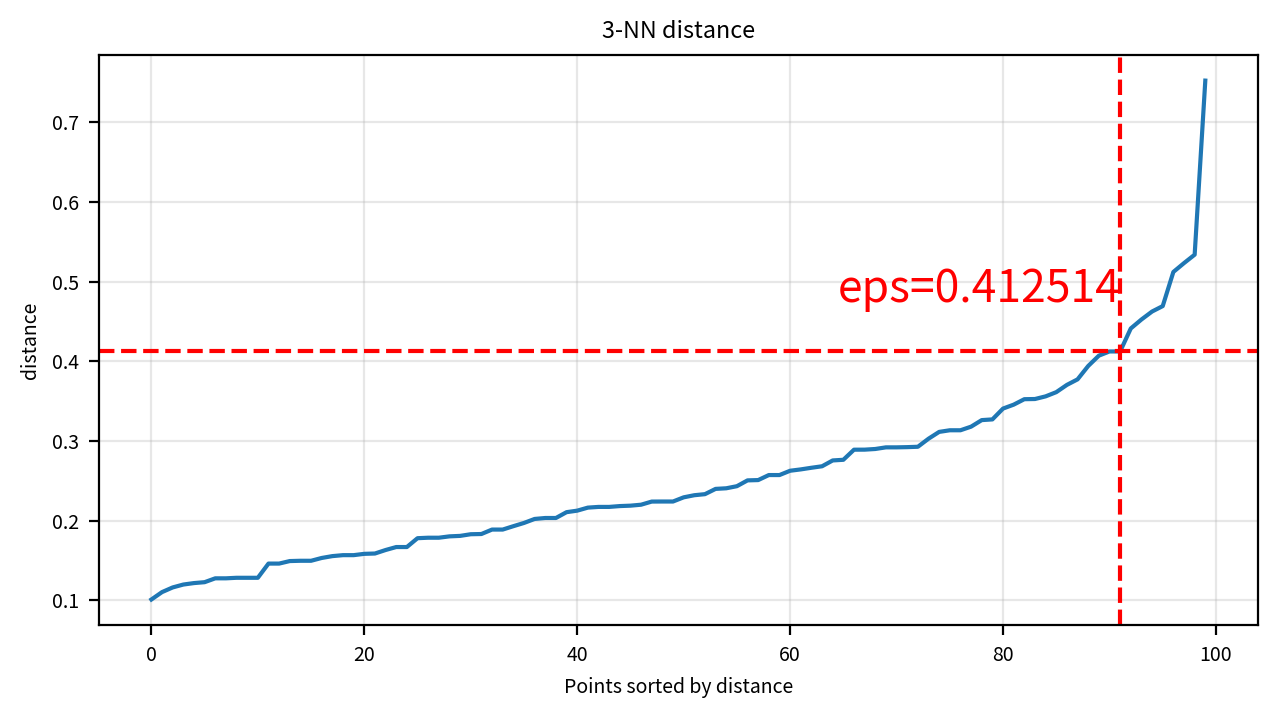

In [10]:
figsize=(1280/my_dpi, 720/my_dpi)
fig, ax=plt.subplots(1, 1, figsize=figsize, dpi=my_dpi)

sb.lineplot(x=range(0, len(target)), y=target)
ax.axhline(eps, color='r', linestyle='--')
ax.axvline(point, color='r', linestyle='--')
ax.text(point, eps+0.05, 'eps=%f'%eps, fontsize=16, color='r', va='bottom', ha='right')

ax.set_title('%d-NN distance'%k)
ax.set_ylabel('distance')
ax.set_xlabel('Points sorted by distance')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.close()

In [11]:
estimator=DBSCAN(eps=eps, min_samples=k, n_jobs=-1)
estimator.fit(df)

result_df=df.copy()
result_df['cluster']=estimator.labels_
result_df.head()

,time spent,game level,cluster
0,-0.250733,1.474805,0
1,0.326494,0.606546,0
2,-0.611500,0.795456,0
3,0.470801,1.674613,1
4,-1.405187,-1.558652,2


In [12]:
result_df2=result_df.copy()
result_df2['vector']='border'
result_df2.loc[estimator.core_sample_indices_, 'vector']='core'
result_df2.loc[result_df2['cluster']==-1, 'vector']='noise'
result_df2.head()

,time spent,game level,cluster,vector
0,-0.250733,1.474805,0,core
1,0.326494,0.606546,0,core
2,-0.611500,0.795456,0,core
3,0.470801,1.674613,1,core
4,-1.405187,-1.558652,2,core


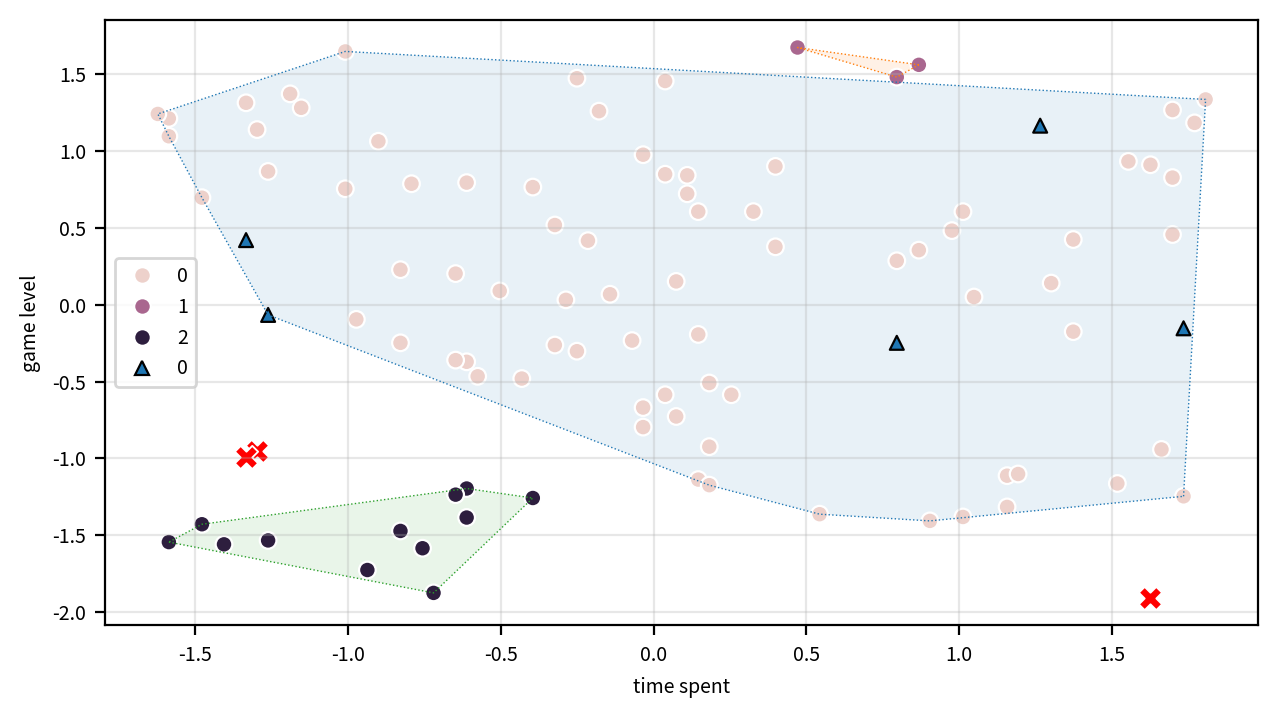

In [14]:
vdf=result_df2.copy()
hue_field='cluster'
x_field='time spent'
y_field='game level'

width_px=1280
height_px=720
rows=1
cols=1
figsize=(width_px/my_dpi, height_px/my_dpi)
fig, ax=plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

for c in vdf[hue_field].unique():
    if c==-1:
        continue
    df_c=vdf.loc[vdf[hue_field]==c, [x_field, y_field]]
    try:
        # 외곽선 좌표 계산
        hull=ConvexHull(df_c)
        # 마지막 좌표 이후에 첫 번째 좌표를 연결
        points=np.append(hull.vertices, hull.vertices[0])
        ax.plot(df_c.iloc[points, 0], df_c.iloc[points, 1], linewidth=0.5, linestyle=':')
        ax.fill(df_c.iloc[points, 0], df_c.iloc[points, 1], alpha=0.1)
    except:
        pass

sb.scatterplot(data=vdf[(vdf[hue_field]!=-1)&(vdf['vector']=='core')], x=x_field, y=y_field, hue=hue_field, edgecolor='white', linewidth=0.8)
sb.scatterplot(data=vdf[(vdf[hue_field]!=-1)&(vdf['vector']=='border')], x=x_field, y=y_field, hue=hue_field, marker='^', s=25, edgecolor='#000', linewidth=0.8)
sb.scatterplot(data=vdf[vdf['vector']=='noise'], x=x_field, y=y_field, color="#FF0000", marker='X', s=70)

ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
plt.close()